# Notebook 7: Allostery

The goal of this workshop is to evolve allosteric elastic networks. How should we define allostery? The most common definition is cooperative allostery.

&nbsp;
&nbsp;


Suppose we have a protein with two binding sites on distance sides of the protein.

&nbsp;

<p align="center">
  <img src="./figures/cooperativity.svg" alt="drawing" width="600"/>
</p>


Copperativity, is defined as,

$$\Delta \Delta G = (G_{10} - G_{00}) - (G_{11} - G_{01})$$

where $G_{10}, G_{00}, G_{11}, G_{01}$ represent the free energies of states 10, 00, 11, 01 repsectively.

If $\Delta\Delta G \neq 0$ it means the binding energy of ligand to the first binding site depend on whether ligand is bound at the distant second site -- Allostery. In this work shop we will used the energy $E$ as a substitute for the free energy $G$. Technically, $E = G$ at zero temperature. 

Our method to compute allostery in our elastic network will be to:
1. Define active site on left side of network.
2. Define allosteric site  on right side of network.
3. Apply displacement to the active site and measure the energy $E_{10}$.
4. Apply displacement to the allosteric site and measure the energy $E_{01}$.
5. Apply displacements to both the active and allosteric site and measure the energy $E_{11}$
6. Compute allostery by $\Delta\Delta E = E_{01} + E_{10} - E_{11}$. $(E_{00} = 0)$

In [147]:
using Revise, LinearAlgebra, PyPlot, LaTeXStrings
push!(LOAD_PATH, "./src/")
using Elastic_N3, Elastic_N4, Elastic_N5, Elastic_N6

In [168]:
W = 20 # width of network
L = 20 # length of network
q = 5 # number of node types
disorder = 0.1 # spatial disorder added to structure
k_min = 1e-2 # softest spring constant in interaction table
k_max = 1e1 # stiffest spring constant in interaction table

# build our network components
r, A = buildStructure(W, L, disorder)
seq = rand(1:q, W*L)
K = buildSpringTable(q, k_min, k_max)
S = seq2Springs(seq, K, A);
H = computeHessian(r, S);
net = Network(seq, r, S, H);

In [169]:
# defined active site and allosteric site
actSiteNodes = [4,5,6,7]
allSiteNodes = W*L .- [4,5,6,7]

# get inidices of active and allosteric site nodes.
actSite = sort([actSiteNodes * 2; actSiteNodes * 2 .- 1])
allSite = sort([allSiteNodes * 2; allSiteNodes * 2 .- 1])

8-element Vector{Int64}:
 785
 786
 787
 788
 789
 790
 791
 792

Here is a little function to automate making random strains for binding sites.

In [170]:
function makeRandStrain(site, r)
    # generate a random strain,
    # rotations and translations and normalize.
    strain = randn(length(site))
    removeTranslationRotation!(strain, r[site])
    normalize!(strain)
    return strain
end

makeRandStrain (generic function with 1 method)

In [171]:
actStrain = makeRandStrain(actSite, r)
allStrain = makeRandStrain(allSite, r)

8-element Vector{Float64}:
 -0.2407355460976337
 -0.04627481443942105
  0.1081576612297293
  0.17790268788934147
  0.4353295909625754
  0.4849692309133506
 -0.30275170609467117
 -0.6165971043632704

Plot the strains at the active and allosteric sites.

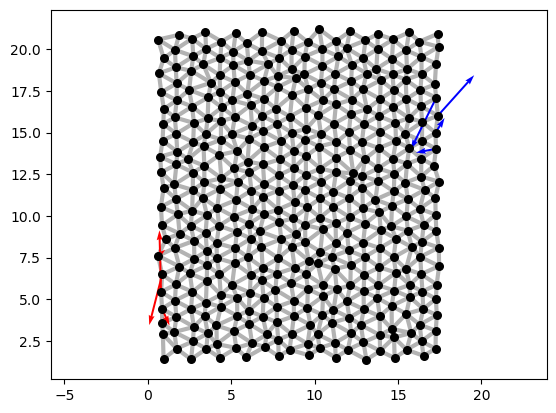

In [172]:
fig, ax = subplots()
plotNetwork!(ax,r, A)

dr_act = zeros(length(r))
dr_act[actSite] = actStrain
plotDisplacment!(ax,r, dr_act, color="red", scale=0.2)

dr_all = zeros(length(r))
dr_all[allSite] = allStrain
plotDisplacment!(ax,r, dr_all, color="blue", scale=0.2)

To measure allostery we need to measure energies, let's define a function for this.

In [173]:
function computeEnergy(net, strain, site)
    E, F, Δr = computeResponse(net.r, net.H, strain, site)
    return E
end

@show computeEnergy(net, actStrain, actSite)
@show computeEnergy(net, allStrain, allSite);

computeEnergy(net, actStrain, actSite) = 1.7952977679789244
computeEnergy(net, allStrain, allSite) = 0.574553237336647


Next lets define a function to compute allostery from the three energies $E_{10}, E_{01}, E_{11}$

In [174]:
allostery(E10, E01, E11) = E10 + E01 - E11

allostery (generic function with 1 method)

Now lets pack the strains and sites for the three different binding conditions into a list.

In [175]:
sites =  [ actSite, allSite, [actSite; allSite]]

3-element Vector{Vector{Int64}}:
 [7, 8, 9, 10, 11, 12, 13, 14]
 [785, 786, 787, 788, 789, 790, 791, 792]
 [7, 8, 9, 10, 11, 12, 13, 14, 785, 786, 787, 788, 789, 790, 791, 792]

In [176]:
sites =  fill([actSite; allSite], 3)

3-element Vector{Vector{Int64}}:
 [7, 8, 9, 10, 11, 12, 13, 14, 785, 786, 787, 788, 789, 790, 791, 792]
 [7, 8, 9, 10, 11, 12, 13, 14, 785, 786, 787, 788, 789, 790, 791, 792]
 [7, 8, 9, 10, 11, 12, 13, 14, 785, 786, 787, 788, 789, 790, 791, 792]

In [177]:
strains =  [ [actStrain; zeros(8)], [zeros(8); allStrain], [actStrain; allStrain]]

3-element Vector{Vector{Float64}}:
 [0.0897682193895211, -0.2031291980260891, -0.019316051386242507, 0.7383763992042445, -0.1556490309778173, -0.6070182598460929, 0.0851968629745388, 0.07177105866793787, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.2407355460976337, -0.04627481443942105, 0.1081576612297293, 0.17790268788934147, 0.4353295909625754, 0.4849692309133506, -0.30275170609467117, -0.6165971043632704]
 [0.0897682193895211, -0.2031291980260891, -0.019316051386242507, 0.7383763992042445, -0.1556490309778173, -0.6070182598460929, 0.0851968629745388, 0.07177105866793787, -0.2407355460976337, -0.04627481443942105, 0.1081576612297293, 0.17790268788934147, 0.4353295909625754, 0.4849692309133506, -0.30275170609467117, -0.6165971043632704]

Since we will be evolving network under a selective pressure for allostery let's define a function that computes a networks allosteric "fitness".

In [178]:
function computeFitness(net::Network, strains, sites)
    # compute the allosteric fitness for a network.
    energies = map( (x,y) -> computeEnergy(net, x, y), strains, sites)
    fitness = allostery(energies[1], energies[2], energies[3])
    return fitness
end

computeFitness (generic function with 1 method)

In [179]:
computeFitness(net, strains, sites)

-0.00011603903622736667